# Circulation Transfer

In [1]:
using PotentialFlow

using Plots
using ProgressMeter
using UnPack

In [2]:
#pyplot()
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12), 
        grid = false)

In [3]:
myred = RGBA(228/255,26/255,28/255,1.0)
myblue = RGBA(55/255,126/255,184/255,1.0)
mygreen = RGBA(77/255,175/255,74/255,1.0)

### Impulse matching correction

In [4]:
"""
    impulse_matching_correction(vs, vt, plate) -> ComplexF64

Compute the impulse matching position correction for a target vortex `vt` when the circulation
of a source vortex `vs` is to be fully transferred to it. Equation (A26) of Darakananda and Eldredge JFM 2019
with Γ̇ = ΓₛΔt. Assumes a flat plate body.
"""
function impulse_matching_correction(vs, vt, plate::Plate)
    @unpack c, α, L = plate
    
    c⁺ = plate.zs[end]
    c⁻ = plate.zs[1]

    z̃t = 2(vt.z - c)*exp(-im*α)/L
    z̃s = 2(vs.z - c)*exp(-im*α)/L
    
    pt = Plates.unit_impulse(z̃t)
    ps = Plates.unit_impulse(z̃s)

    η = z̃t/(√(z̃t + 1)*√(z̃t - 1))

    Δp = ps - pt
    Δz = im*0.5L*exp(im*α)*(Δp*(1 + η') + Δp'*(η' - 1))/(η + η')*(circulation(vs)/circulation(vt))
#     if isnan(Δz) || isinf(Δz)
#         error("Δz is $Δz")
#     end
    return Δz
end

impulse_matching_correction

In [5]:
"""
    total_impulse(point,plate) -> ComplexF64

Return the total linear impulse of vortex `point` and its modification due to the presence of plate `plate`.
"""
function total_impulse(point, plate)
    @unpack c, α, L = plate
    
    z = Elements.position(point)
    Γ = circulation(point)

    z̃ = 2exp(-im*α)*(z - c)/L
    exp(im*α)*0.5L*Γ*(imag(z) - im*real(√(z - 1)*√(z + 1)))
end

"""
    transfer_circulation!(sheet,point,Δz,plate,ϵ=1e-3;[max_segments=10]) -> Vortex.Blob

Return a vortex blob that is initially identical to `point` and, where appropriate,
accrues the circulation of the last several segments of the vortex sheet `sheet`.
In these cases, it also removes the last several segments of `sheet`. The position
correction `Δz`, which accounts for the impulse matching correction due to the
transfer of circulation from each segment, is added to the position of `point`
to create the output vortex blob. `ϵ` is the maximum allowable discrepancy in
the impulse due to the circulation transfer (compared to the impulse if no circulation
is transferred). `max_segments` is the maximum number of sheet segments that can be considered
for transfer; it defaults to 10.
"""
function transfer_circulation!(sheet, point, Δz, plate, ϵ = 1e-3; max_segments=10)
    z₀  = Elements.position(point)
    Γ₀  = circulation(point)

    ΣΔz = zero(ComplexF64)
    ΣΓ = 0.0

    Σp = total_impulse(Vortex.Point(z₀, Γ₀), plate)

    segments = 0
    
    # If the sheet isn't long enough to transfer, then return with no transfer
    if length(sheet) < max_segments+2
        return point
    end

    for n in 1:length(sheet)-max_segments  # Don't eat into the last `max_segments` segments
        if isnan(Δz[n]) || isinf(Δz[n])
            if n ≤ 2
                return point
            else
                segments = n-1
                break;
            end
        end

        ΣΔz += Δz[n]
        ΣΓ  += circulation(sheet.blobs[n])

        p₊ = total_impulse(Vortex.Point(z₀ + ΣΔz, Γ₀ + ΣΓ), plate) # impulse of active vortex with this segment transferred
        Σp += total_impulse(sheet.blobs[n], plate)  # impulse of the sheet if this segment is not transferred

        if abs2(p₊ - Σp) > ϵ^2
            if n ≤ 2
                return point
            else
                segments = n-1
                break
            end
        end
        segments += 1
    end
    
    # Change the position and strength of `point`, using the impulse correction
    # and strength of each segment
    z = z₀ + sum(Δz[1:segments-1]) + 0.5Δz[segments]
    Γ = Γ₀ + sum(circulation(sheet.blobs[1:segments-1])) +
                 0.5(sheet.Ss[segments] -sheet.Ss[segments-1])
    point₊ = Vortex.Blob(z, Γ, point.δ)

    # Remove the transferred segments from the sheet
    splice!(sheet.blobs, 1:segments-1)
    splice!(sheet.Ss, 1:segments-1)
    sheet.blobs[1] = sheet.blobs[1](Γ = 0.5(sheet.Ss[2] - sheet.Ss[1]))

    return point₊
end

transfer_circulation!

### Motion Parameters

### Time Marching Deatils

In [6]:
function compute_ẋ!(ẋ, x, t)
   plate, ambient_sys = x
    motion = ẋ[1]
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    Plates.enforce_no_flow_through!(plate, motion, ambient_sys, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

The centers of new vortex sheet segments are placed a third of the distance between the edges of the plate to last segment of sheet:

In [69]:
"""
    new_vortex(edge,angle,δ,plate,motion) -> Vortex.Blob

Create a new vortex blob near the edge `edge` of the plate, with unit strength
"""
new_vortex(edge, α, δ, plate, motion) = Vortex.Blob(edge - 1e-2im*exp(im*α)*sign(Plates.normal(motion.ċ+im*motion.α̇*(edge-plate.c),α)), 1.0, δ)


"""
    new_vortex(blobs::Vector{Vortex.Blob},edge,angle,δ,plate,motion) -> Vortex.Sheet

Create a new vortex sheet near the edge `edge` of the plate with unit strength, using the vortex blobs in `blobs`
to place the sheet segments. (The blobs are placed at the sheet segment centroids.)
"""
function new_vortex(blobs::Vector{T}, edge, α, δ, plate, motion) where T <: Vortex.Blob
    Δz = (blobs[end].z - edge)/2 
    Vortex.Sheet([0.5, 1.5] .* Δz .+ edge, [0.0, 1.0], δ)
end

"""
    new_vortex(blobs::Vector{Vortex.Blob},sheet::Vortex.Sheet,edge,angle,δ,plate,motion) -> Vortex.Blob

Create vortex blobs near the edge `edge` of the plate with unit strength, using the last vortex sheet segment in `sheet`
to place the blobs.
"""
function new_vortex(::Vector{T}, sheet::Vortex.Sheet, edge, α, δ, plate, motion) where T <: Vortex.Blob
    z = (edge + 2sheet.zs[end])/3
    Vortex.Blob.([sheet.zs[end], z], [0.5, 0.5], δ)
end


"""
    shed_new_vorticity!(sys,motion,δ,t,lesp=0.0,tesp=0.0) 

Returns the plate/vortex system after adding new vortices of the appropriate type
at the plate edges, in order to satisfy the respective regularization conditions at those edges.
"""
function shed_new_vorticity!(sys, motion, δ, t, lesp = 0.0, tesp = 0.0)
    plate, ambient_sys = sys
    le_sys, te_sys = ambient_sys


    nlev = new_vortex(le_sys..., plate.zs[end], plate.α, δ, plate, motion)
    ntev = new_vortex(te_sys..., plate.zs[1], plate.α, δ, plate, motion)

    Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, nlev, ntev, t, lesp, tesp)

    plate, (add_new_vortex!(le_sys..., nlev, Γ₊), add_new_vortex!(te_sys..., ntev, Γ₋))

end

"""
    add_new_vortex!(blob::Vortex.Blob,Γ) -> (blob,)

Create a new vortex blob with the position and radius of `blob`, but with strength `Γ`,
unless `Γ` is zero, in which case it returns an empty tuple.
"""
function add_new_vortex!(b::Vortex.Blob, Γ)
    if Γ != 0
        ([Vortex.Blob(b.z, Γ, b.δ)],)
    else
        ()
    end
end

"""
    add_new_vortex!(blobs::Vector{Vortex.Blob},sheet,Γ) -> (blob,)

Return blobs and a sheet with the same positions and radii as `sheet`, but with the strengths
set to 0 and `Γ`. This is meant for cases in which the sheet is initially created.
"""
function add_new_vortex!(blobs::Vector{T}, sheet::Vortex.Sheet, Γ) where T <: Vortex.Blob
    blobs, Vortex.Sheet(sheet.zs, [0.0, Γ], sheet.blobs[1].δ)
end

"""
    add_new_vortex!(blobs::Vector{Vortex.Blob},sheet,segment::Vector{Vortex.Blob},Γ) -> (blob,)

Return blobs and a sheet that appends the last vortex in `segment` to `sheet`, with strength `Γ`.
"""
function add_new_vortex!(blobs::Vector{T}, sheet::Vortex.Sheet, segment::Vector{T}, Γ) where T <: Vortex.Blob
    Vortex.Sheets.append_segment!(sheet, segment[2].z, Γ)
    blobs, sheet
end

#=
function new_vortex(sys::Tuple{Vector{T}}, edge, α, δ) where T <: Vortex.Blob
    Δz = (sys[1][end].z - edge)/2 

    Vortex.Sheet([0.5, 1.5] .* Δz + edge, [0.0, 1.0], δ)
end

function new_vortex(sys::Tuple{Vector{T}, Vortex.Sheet}, edge, α, δ) where T <: Vortex.Blob
    _, sheet = sys

    z = (edge + 2sheet.zs[end])/3

    Vortex.Blob.([sheet.zs[end], z], [0.5, 0.5], δ)
end
=#

"""
    new_element() -> ()

Returns an empty tuple
"""
new_element() = ()

"""
    new_element(blobs::Vector{Vortex.Blob}) -> (Vortex.Blob,)

Returns the most recently added vortex in `blobs`
"""
new_element(blobs::Vector{T}) where T <: Vortex.Blob = (blobs[1],) 

"""
    new_element(blobs::Vector{Vortex.Blob},sheet::Vortex.Sheet) -> (Vortex.Blob,) 

Returns the most recently added vortex in `sheet`
"""
function new_element(blobs::Vector{T}, sheet::Vortex.Sheet) where T <: Vortex.Blob
    (sheet.blobs[end],)
end

new_element

## Comparison with Theodorsen 

First, let's set up the exact solution

In [70]:
C(κ::Float64) = hankelh2(1,κ)/(hankelh2(1,κ)+im*hankelh2(0,κ))

struct Theodorsen
    kin :: RigidBodyMotions.PitchHeave
    L   :: Float64
end

function (theo::Theodorsen)(t::Float64)
    @unpack L, kin = theo
    @unpack Y,Ẏ,U₀,α,a,α̇,Ÿ,α̈,K = kin
    # defined for motion in +x direction
    ReΓb = π*L*(-Ẏ(t) + U₀*α(t) + (1/4 + a)*L*α̇(t))
    ImΓb = π*L*(-2K*Y(t) - U₀*α̇(t)/(2K) + (1/4 + a)*L*2K*α(t))
    fy = π*(L/2)^2*(-Ÿ(t) + a*α̈(t) + U₀*α̇(t)) + U₀*real((ReΓb+im*ImΓb)*C(K))
    momp = π*(L/2)^2*(a*Ÿ(t)-(L^2/32+a^2)*α̈(t)-(L/4+a)*U₀*α̇(t)) + (L/4-a)*U₀*real((ReΓb+im*ImΓb)*C(K))
    return fy, momp+a*fy
end

Now set up the problem parameters and kinematic

In [71]:
L = 1.0   # chord length

N = 128   # number of plate control points

Δt = 1e-2; # time step
δ = 0.1 #0.01
lesp = 10 #0.1
tesp = 0.0

a = 0.25 # location of pitch axis, a = 0.5 is leading edge
ϕ = -π/2  # phase lag of pitch to heave
A = 0.0  # amplitude/chord
fstar = 1/π # fc/U
α₀ = 0 # mean angle of attack
Δα = 2π/180 # amplitude of pitching

K = π*fstar # reduced frequency, K = πfc/U
println("f* = ",fstar)
println("Δα = ",Δα*180/π)
println("α(1/4) = ",abs(atan(2*K*A)-Δα)*180/π)
println("A/c = ",A)
println("K = ",K)

oscil = RigidBodyMotions.PitchHeave(1.0,a,K,ϕ,α₀,Δα,A);

f* = 0.3183098861837907
Δα = 2.0
α(1/4) = 2.0
A/c = 0.0
K = 1.0


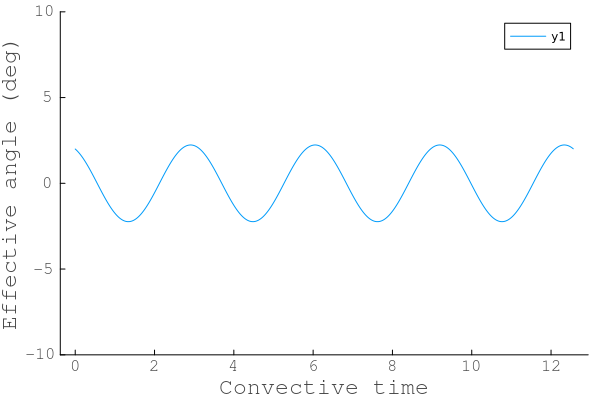

In [72]:
t = 0:0.01:(4.0./fstar)
#plot(t,oscil.Ẏ.(t))
#plot!(t,oscil.α̇.(t))
Vy = map(x -> imag(x[1]),oscil.(t))
αeff = atan.(-Vy)+oscil.α.(t)
plot(t,αeff*180/π,ylim=(-10,10),ylabel="Effective angle (deg)",xlabel="Convective time")

Run it!

In [77]:
plate = Plate(N, L, 0, oscil.α(0.0))
motion = Plates.RigidBodyMotion(oscil);
Plates.enforce_no_flow_through!(plate, motion, (), 0.0)

sys = (plate, ((), ()))
#sys = (plate, ())


# sys[1] is the plate, sys[2] is the vortex system
# sys[2][i] corresponds to edge i (i = 1 is leading edge, i = 2 is trailing edge)
# sys[2][i][1] is the set of blobs associated with edge i
# sys[2][i][2] is the vortex sheet associated with edge i
# sys[2][i][1][1] is the current active vortex for edge i

sys = shed_new_vorticity!(sys, motion, δ, 0.0, lesp, 0.0)
states = Tuple[];
forces = [];
moments = [];

tf = 12
T = Δt:Δt:tf

# Set up Theodorsen solution results
#theo = Theodorsen(oscil,L)
#fytheo = map(x -> x[1], theo.(Δt:Δt:tf))
#momtheo = map(x -> x[2], theo.(Δt:Δt:tf))

counter = [0, 0]
ϵ = 1e-3 #1.75e-4 #1e-3
countermin = [Inf,20] #[Inf,Inf]
@showprogress for t in T
    push!(states, deepcopy(sys))

    # Perform the impulse matching correction on the active vortex position, but only if there is a sheet and vortex
    Δzs = [length(sys[2][i]) == 2 ? [impulse_matching_correction(sblob, sys[2][i][1][1], sys[1]) for sblob in sys[2][i][2].blobs] : [] for i in 1:2]
    
    ẋs = (motion, allocate_velocity(sys[2]))
    compute_ẋ!(ẋs, sys, t)
    
    lesys, tesys = sys[2]
    push!(forces, Plates.force(plate, motion, sys[2], ẋs[2], (new_element(lesys...)..., new_element(tesys...)...), Δt))   
    push!(moments, Plates.moment(plate, motion, sys[2], ẋs[2], (new_element(lesys...)..., new_element(tesys...)...), Δt))   

    
    advect!(sys, sys, ẋs, Δt)
    
    for i in 1:2  # each edge
#         @show sys[2][i]
        if length(sys[2][i]) != 2
#             @show "! $i"
            continue
        end
        point = transfer_circulation!(sys[2][i][2], sys[2][i][1][1], Δzs[i], plate, ϵ)
        if point == sys[2][i][1][1]
            counter[i] += 1
#             @show ":( $i)"
        else
#             @show i
            counter[i] = 0
            sys[2][i][1][1] = point
        end
        if length(sys[2][i][2]) > 2 && counter[i] > countermin[i]
            tips = sys[2][i][2].blobs[1:2]
            newPoint = Vortex.Blob(0.5*(tips[1].z + tips[2].z), 2circulation(tips[1]), tips[1].δ)
            splice!(sys[2][i][2].blobs, 1)
            splice!(sys[2][i][2].Ss, 1)
            sys[2][i][2].blobs[1] = Vortex.Blob(tips[2].z, 0.5*(sys[2][i][2].Ss[2] - sys[2][i][2].Ss[1]), tips[2].δ)
            pushfirst!(sys[2][i][1], newPoint) # used to be unshift!
            counter[i] = 0
        end
    end
    
    length(sys[2][1]) == 2 && Sheets.arclength(sys[2][1][2]) ≥ 50Δt && Sheets.filter!(sys[2][1][2], 2Δt, 8Δt)
    length(sys[2][2]) == 2 && Sheets.arclength(sys[2][2][2]) ≥ 50Δt && Sheets.filter!(sys[2][2][2], 2Δt, 8Δt)
    
    # or remeshing instead
    #length(sys[2][1]) == 2 && Sheets.arclength(sys[2][1][2]) ≥ 30Δt && Sheets.remesh!(sys[2][1][2],2Δt)
    #length(sys[2][2]) == 2 && Sheets.arclength(sys[2][2][2]) ≥ 30Δt && Sheets.remesh!(sys[2][2][2],2Δt)
    
    Plates.enforce_no_flow_through!(plate, motion, sys[2], t)
    sys = shed_new_vorticity!(sys, motion, δ, t, lesp, 0.0)
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


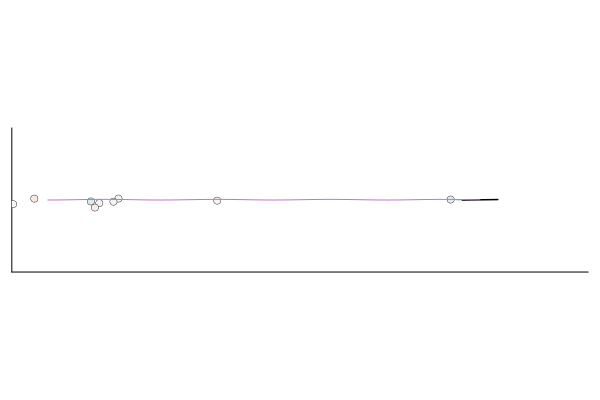

In [78]:
plt = plot(states[1200],color = cgrad(:RdBu,rev=true), ratio=1,legend=:none,markersize=4,markerstrokealpha=1,
            markerstrokewidth=0.5,linewidth=1.5,ticks=nothing,border=nothing,framestyle=false,
            clim=(-0.5,0.5),ylim=(-2,2),xlim=(-1,15))
zc = map(x -> 0.5x[1].zs[64] + 0.5x[1].zs[65],states[1:end]) 
plot!(real.(zc),imag.(zc))
#savefig("oscil-alf05A05-sheet.pdf")
#savefig("oscil-alf05A05-eps175em3tmin1em1.pdf")
plt

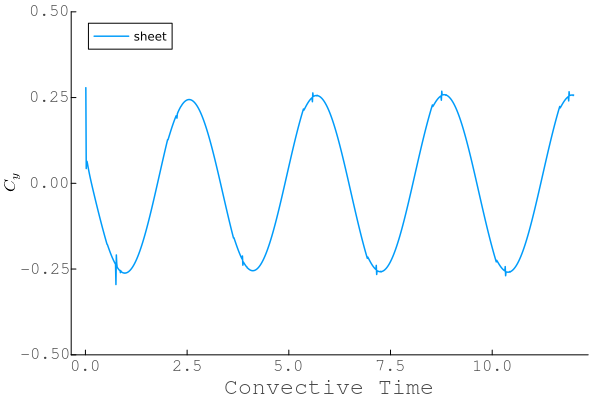

In [79]:
plt = plot(ylabel = "\$C_y\$", ylim = (-0.5,0.5), 
    xlabel = "Convective Time")
#plot!(Δt:Δt:tf, 2imag.(forces_tmin1em1), linewidth = 1.5, linestyle = :solid, label = "\$T_{min}=0.1\$")
#plot!(Δt:Δt:tf, 2imag.(forces_tmin4em1), linewidth = 1.5, linestyle = :solid, label = "\$T_{min}=0.4\$")
plot!(Δt:Δt:tf, 2imag.(forces), linewidth = 1.5, linestyle = :solid, label = "sheet")
#plot!(Δt:Δt:tf, 2fytheo, linewidth = 1, linestyle = :dash, color = :black, label = "Theodorsen")
#savefig("oscil-forces.pdf")
plt

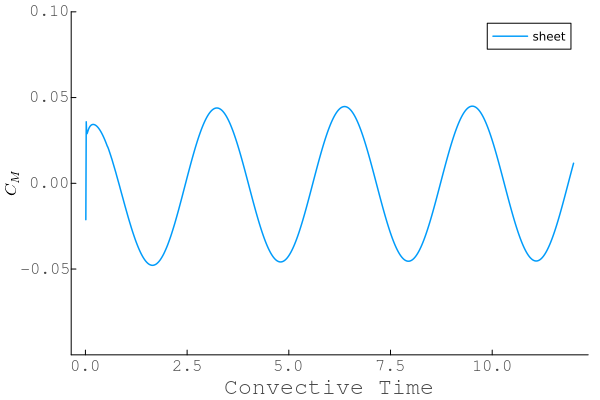

In [38]:
plt = plot(ylabel = "\$C_M\$", ylim = (-0.1,0.1), 
    xlabel = "Convective Time")
#plot!(Δt:Δt:tf, 2moments_tmin1em1, linewidth = 1.5, linestyle = :solid, label = "\$T_{min}=0.1\$")
#plot!(Δt:Δt:tf, 2moments_tmin4em1, linewidth = 1.5, linestyle = :solid, label = "\$T_{min}=0.4\$")
plot!(Δt:Δt:tf, 2moments, linewidth = 1.5, linestyle = :solid, label = "sheet")
#plot!(Δt:Δt:tf, 2momtheo, linewidth = 1, linestyle = :dash, color = :black, label = "Theodorsen")

#### Calculate error and number of elements

In [39]:
println("Error from reference = ",norm(forces_tmin1em1-forces_ref)/norm(forces_ref))
println("Total number of vortex elements at tf = ",sum(length(states_tmin1em1[end][2][j][i]) for i = 1:2, j = 2))
println("Total number of vortex elements in ref at tf = ",sum(length(states_ref[end][2][j][i]) for i = 1:2, j = 2))

LoadError: UndefVarError: `forces_tmin1em1` not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [235]:
println("Error from reference = ",norm(forces_tmin4em1-forces_ref)/norm(forces_ref))
println("Total number of vortex elements at tf = ",sum(length(states_tmin4em1[end][2][j][i]) for i = 1:2, j = 2))
println("Total number of vortex elements in ref at tf = ",sum(length(states_ref[end][2][j][i]) for i = 1:2, j = 2))

Error from reference = 0.004194867745700374
Total number of vortex elements at tf = 386
Total number of vortex elements in ref at tf = 2208


## Evaluation of Kinsey and Dumas results

In [49]:
L = 1.0   # chord length
ċ = L  # translation velocity
# α = π/3#*ramp(0)#π/30    # angle of attack

N = 128   # number of plate control points

Δt = 1e-2; # time step
δ = 0.05 #0.01
lesp = 10.0 #0.1
tesp = 0.0

a = 0.5 #0.2 # location of pitch axis, a = 0.5 is leading edge
ϕ = -π/2  # phase lag of pitch to heave
A = 0.0 #1.0  # amplitude/chord
fstar = 0.14 # fc/U
α₀ = 0π/180 # mean angle of attack
Δα = 5π/180 #20π/180 # amplitude of pitching

# specify feathering parameter
#χ = 1.0  # feathering parameter
#Δα = χ*atan(2π*A*fstar)
#fstar = tan(Δα/χ)/(2π*A)
#println("α(1/4) = ",α₀/χ - α₀)
χ = Δα/atan(2π*A*fstar)
K = π*fstar # reduced frequency, K = πfc/U
println("f* = ",fstar)
println("Δα = ",Δα*180/π)
println("α(1/4) = ",abs(atan(2*K*A)-Δα)*180/π)
println("K = ",K)
println("χ = ",χ)


oscil = RigidBodyMotions.PitchHeave(1.0,a,K,ϕ,α₀,Δα,A);

f* = 0.14
Δα = 5.0
α(1/4) = 5.0
K = 0.4398229715025711
χ = Inf


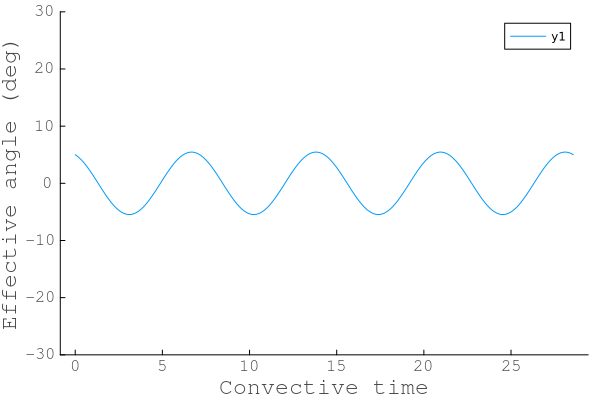

In [50]:
t = 0:0.01:(4.0./fstar)
#plot(t,oscil.Ẏ.(t))
#plot!(t,oscil.α̇.(t))
Vy = map(x -> imag(x[1]),oscil.(t))
αeff = atan.(-Vy)+oscil.α.(t)
plot(t,αeff*180/π,ylim=(-30,30),ylabel="Effective angle (deg)",xlabel="Convective time")

In [60]:
plate = Plate(N, L, 0, oscil.α(0.0))
motion = Plates.RigidBodyMotion(oscil);
Plates.enforce_no_flow_through!(plate, motion, (), 0.0)

sys = (plate, ((), ()))

# sys[1] is the plate, sys[2] is the vortex system
# sys[2][i] corresponds to edge i (i = 1 is leading edge, i = 2 is trailing edge)
# sys[2][i][1] is the set of blobs associated with edge i
# sys[2][i][2] is the vortex sheet associated with edge i
# sys[2][i][1][1] is the current active vortex for edge i

sys = shed_new_vorticity!(sys, motion, δ, 0.0, lesp, 0.0)
states = Tuple[];
forces = [];

tf = 60
T = Δt:Δt:tf

counter = [0, 0]
ϵ = 1e-3 #0 #1e-3
countermin = [10,10] #[10,10] #[Inf, Inf]
@showprogress for t in T
    push!(states, deepcopy(sys))

    # Perform the impulse matching correction on the active vortex position, but only if there is a sheet and vortex
    Δzs = [length(sys[2][i]) == 2 ? [impulse_matching_correction(sblob, sys[2][i][1][1], sys[1]) for sblob in sys[2][i][2].blobs] : [] for i in 1:2]
    
    ẋs = (motion, allocate_velocity(sys[2]))
    compute_ẋ!(ẋs, sys, t)
    
    push!(forces, Plates.force(plate, motion, sys[2], ẋs[2], (new_element(sys[2][1]...)..., new_element(sys[2][2]...)...), Δt))   
    advect!(sys, sys, ẋs, Δt)
    
    for i in 1:2  # each edge
#         @show sys[2][i]
        if length(sys[2][i]) != 2
#             @show "! $i"
            continue
        end
        point = transfer_circulation!(sys[2][i][2], sys[2][i][1][1], Δzs[i], plate, ϵ)
        if point == sys[2][i][1][1]
            # nothing was done to the active blob in this step.
            counter[i] += 1
#             @show ":( $i)"
        else
#             @show i
            counter[i] = 0
            sys[2][i][1][1] = point
        end
        if length(sys[2][i][2]) > 2 && counter[i] > countermin[i]
            # convert current active vortex into an inactive one, and release tip of sheet as new active vortex
            tips = sys[2][i][2].blobs[1:2]
            # factor of 2 in circulation is due to the trapezoidal weight on blob strength of first blob
            newPoint = Vortex.Blob(0.5*(tips[1].z + tips[2].z), 2circulation(tips[1]), tips[1].δ)
            splice!(sys[2][i][2].blobs, 1)
            splice!(sys[2][i][2].Ss, 1)
            # now the second blob is the first blob and needs to have its strength adjusted for trapezoidal weight
            sys[2][i][2].blobs[1] = Vortex.Blob(tips[2].z, 0.5*(sys[2][i][2].Ss[2] - sys[2][i][2].Ss[1]), tips[2].δ)
            pushfirst!(sys[2][i][1], newPoint) # used to be unshift!
            counter[i] = 0
        end
    end
    
    length(sys[2][1]) == 2 && Sheets.arclength(sys[2][1][2]) ≥ 50Δt && Sheets.filter!(sys[2][1][2], 2Δt, 8Δt)
    length(sys[2][2]) == 2 && Sheets.arclength(sys[2][2][2]) ≥ 50Δt && Sheets.filter!(sys[2][2][2], 2Δt, 8Δt)
    
    # or remeshing instead
    #length(sys[2][1]) == 2 && Sheets.arclength(sys[2][1][2]) ≥ 30Δt && Sheets.remesh!(sys[2][1][2],2Δt)
    #length(sys[2][2]) == 2 && Sheets.arclength(sys[2][2][2]) ≥ 30Δt && Sheets.remesh!(sys[2][2][2],2Δt)
    
    Plates.enforce_no_flow_through!(plate, motion, sys[2], t)
    sys = shed_new_vorticity!(sys, motion, δ, t, lesp, 0.0)
    

end
println("Total number of vortex elements at tf = ",sum(length(states[end][2][j][i]) for i = 1:2, j = 2))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Total number of vortex elements at tf = 31


In [61]:
length(states)

6000

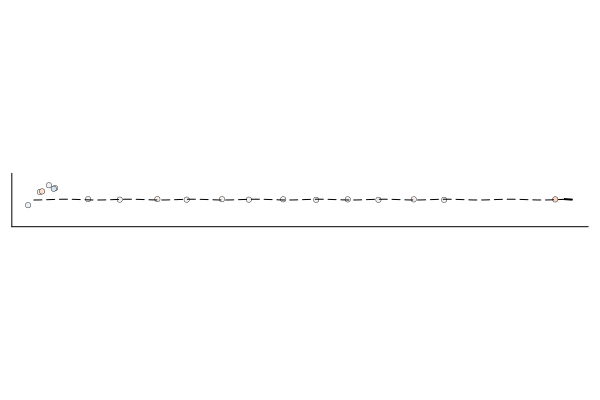

In [62]:
plt = plot(states[end],color = cgrad(:RdBu,rev=true), ratio=1,legend=:none,markersize=3,markerstrokealpha=1,
            markerstrokewidth=0.5,linewidth=2,ticks=nothing,border=nothing,framestyle=false,
            clim=(-1,1),ylim=(-3,3)) #,xlim=(-2,13))
zc = map(x -> 0.5x[1].zs[64] + 0.5x[1].zs[65],states[1:end]) 
plot!(real.(zc),imag.(zc),linestyle=:dash,color=:black,linewidth=1)
#savefig("oscil-alf60A1-eps1em3tmin02-t50.pdf")
#savefig("oscil-alf20A1-sheet-t12.pdf")
plt

In [66]:
for n in [20, 50, 100]
    plot(states[n], ratio=1, markersize = 3, markerstrokealpha = 0, linewidth=1,
          color = cgrad(:RdBu,rev=true), clim = (-0.02, 0.02), legend = :none,
        ylim = (-1.2,0.5), xlim = real(states[n][1].zs[end]) .+ (-2, 0.1), size = (200, 160))
    #plot!(filter(b -> circulation(b) < 0, states[n][2][1][1]), marker_z = nothing, markersize = 3, markerstrokealpha = 0, markercolor = :white)
    #savefig("pitchup_k07_d10_t$(lpad(n, 3, 0)).pdf")
end

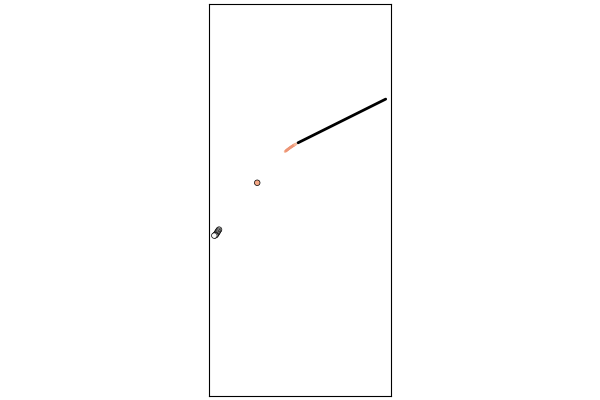

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [12]:
plt = plot(states[100],color = :RdBu_r, ratio=1,legend=:none,markersize=4,markerstrokealpha=1,
            markerstrokewidth=0.5,linewidth=2,ticks=nothing,border=nothing,framestyle=false,
            clim=(-1,1),ylim=(-2,2))

In [89]:
180*pitchup.α.([0.2, 0.5, 1.5])/π

3-element Array{Float64,1}:
  0.383144
 16.0873  
 89.3972  

In [286]:
forces_alf20A1_eps1em3cmin20 = deepcopy(forces);
states_alf20A1_eps1em3cmin20 = deepcopy(states);

In [297]:
forces_alf20A1_sheet = deepcopy(forces_sheet);
states_alf20A1_sheet = deepcopy(states_sheet);

In [171]:
plot(T,180pitchup_k07.α.(T)/π,xlim = (0,5), ylim = (0,100),legend=false)
plot!(T,180pitchup_k02.α.(T)/π,xlim = (0,5), ylim = (0,100),legend=false)
savefig("pitchup_alpha.pdf")

In [295]:
length(forces_alf20A1_eps1em3cmin20)

5000

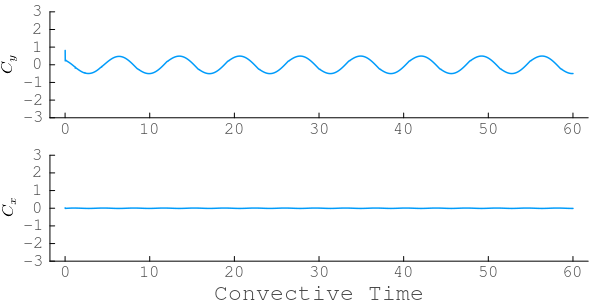

In [64]:
Vy = map(x -> imag(x[1]),oscil.(Δt:Δt:50))
plt = plot(layout = (2,1), 
    ylabel = ["\$C_y\$" "\$C_x\$"], ylim = [(-3,3) (-3, 3)], 
    xlabel = ["" "Convective Time"], size = (600, 300), legend = :none)
plot!((Δt:Δt:60), [2imag.(forces) 2real.(forces)], linewidth = 1.5, linestyle = :solid)
#plot!((Δt:Δt:12), [2imag.(forces_alf20A1_sheet) 2real.(forces_alf20A1_sheet)], linewidth = 1.5, linestyle = :solid)
#plot!((Δt:Δt:tf), [Vy Vy])
#savefig("oscil-force-alf20A1.pdf")
plt

In [439]:
mean(2real.(forces_alf20A1_eps1em3cmin20))

0.8254777667281494

In [442]:
mean(imag.(forces_alf20A1_eps1em3cmin20).*Vy)

-0.5356737589022174

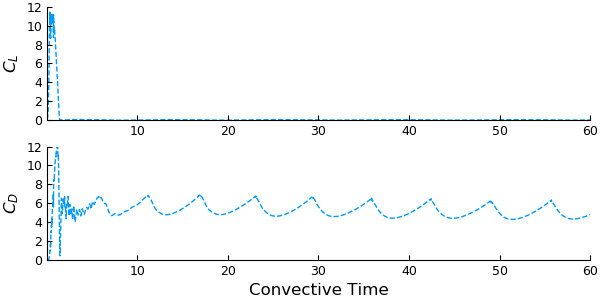

In [147]:
plt = plot(layout = (2,1), 
    ylabel = ["\$C_L\$" "\$C_D\$"], ylim = [(0, 12) (0, 12)], 
    xlabel = ["" "Convective Time"], size = (600, 300), legend = :none)
plot!(Δt:Δt:tf, [2imag.(forces) -2real.(forces)], linewidth = 1, linestyle = :dash)
# sheet_forces = open(deserialize, "aoa60_sheet_force.dat")
# plot!(plt, range(Δt, Δt, length(sheet_forces)), [2imag.(sheet_forces) -2real.(sheet_forces)], linewidth = 2, label="Sheet Only", legend = :none)
#savefig("pitchup07_hybrid_force.pdf")
plt